In [1]:
import pickle
import sys
import os

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import rioxarray as rxr
import xarray as xr
import geopandas as gpd

import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

# Applying to elephants

In [2]:
# Parameters
model_to_use = 'pymer' # "pymer" or "rf" or "xgboost"
species = 'african savannah' # "african forest" or "african savannah" or "asian"
save_raster = False

In [3]:
# Read in the predictor raster stack
predictor_stack_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/hunting_predictor_stack/hunting_predictor_stack_buffered.tif'
predictor_stack = rxr.open_rasterio(predictor_stack_fp, band_as_variable = True)

#  correcting the variable names
predictor_stack = predictor_stack.rename({band : predictor_stack[band].attrs['long_name'] for band in predictor_stack})

predictor_stack

<xarray.Dataset> Size: 2GB
Dimensions:                  (x: 15985, y: 4195)
Coordinates:
  * x                        (x) float64 128kB -110.4 -110.4 ... 155.9 156.0
  * y                        (y) float64 34kB 34.99 34.97 ... -34.89 -34.91
    spatial_ref              int64 8B 0
Data variables:
    Dist_Settlement_KM       (y, x) float32 268MB ...
    Stunting_Pct             (y, x) float32 268MB ...
    Literacy_Rate            (y, x) float32 268MB ...
    Travel_Time_Large        (y, x) float32 268MB ...
    Livestock_Biomass        (y, x) float32 268MB ...
    Population_Density       (y, x) float32 268MB ...
    Percent_Settlement_50km  (y, x) float32 268MB ...
    Protected_Area           (y, x) float32 268MB ...
Attributes:
    AREA_OR_POINT:  Area

In [4]:
# Reading the tropical forest extent polygon for masking non-forest pixels
tropical_zone_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/tropical_forest_extent/tropical_forest_extent.shp'

tropical_zone = gpd.read_file(tropical_zone_fp)
tropical_zone = [tropical_zone.geometry.iloc[0]]

In [5]:
# Reading the full mammal_recreated dataset for z-score stats
mammals_data_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/benitez_lopez2019_recreated/benitez_lopez2019_recreated_w_original.csv'
mammals_data = pd.read_csv(mammals_data_fp)

#  columns to use
cols_to_normalize = list(predictor_stack.keys())
cols_to_normalize.remove('Protected_Area')

#  extract columns means + standard deviations
mammals_cols_to_normalize = mammals_data[cols_to_normalize]
if model_to_use == 'pymer':
    mammals_cols_to_normalize = mammals_cols_to_normalize.replace(0, 0.1)
    mammals_cols_to_normalize = np.log10(mammals_cols_to_normalize)
    
col_means = mammals_cols_to_normalize.mean(axis = 0)
col_stds = mammals_cols_to_normalize.std(axis = 0)

In [6]:
# Applying data preprocessing
for pred in cols_to_normalize:
    temp = predictor_stack[pred]
    
    if pred == 'Dist_Settlement_KM':
        temp = temp / 1000 # converting to actual km

    #  log10-transforming continuous vars (just linear hurdle)
    if model_to_use == 'pymer':
        temp = temp.where(temp != 0, other = 0.1) # making sure there aren't issues w/taking the log
        temp = xr.ufuncs.log10(temp)
    
    #  z-score normalization
    temp = temp - col_means[pred]
    temp = temp / col_stds[pred]

    #  slotting the preprocessed version back into the dataset
    predictor_stack[pred] = temp

In [7]:
# Read in the saved predictive model
model_base_path = '/Users/emiliolr/Google Drive/My Drive/LIFE/hunting_analysis/final_models'
model_fps = {'rf' : 'rf_hurdle_10.0mins.pkl',
             'xgboost' : 'xgboost_hurdle_10.0mins.pkl',
             'pymer' : 'pymer_hurdle.pkl'}

model_fp = os.path.join(model_base_path, model_fps[model_to_use])

with open(model_fp, 'rb') as f:
    model = pickle.load(f)

model

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


HurdleModelEstimator(data_args={'dataset': 'mammals_recreated',
                                'outlier_cutoff': 5.0,
                                'rebalance_dataset': False},
                     extirp_pos=False,
                     nonzero_model=<model_utils.PymerModelWrapper object at 0x416ddc830>,
                     prob_thresh=0.9, verbose=True,
                     zero_model=<model_utils.PymerModelWrapper object at 0x325d31940>)

In [8]:
# Reading in the relevant elephant AOH
aoh_base_fp = '/Users/emiliolr/Desktop/phd-exploratory-work/data/elephants'
aoh_fps = {'african forest' : '181007989_RESIDENT.tif',
           'african savannah' : '181008073_RESIDENT.tif', 
           'asian' : '7140_RESIDENT.tif'}

aoh_fp = os.path.join(aoh_base_fp, aoh_fps[species])
aoh = rxr.open_rasterio(aoh_fp)

aoh

<xarray.DataArray (band: 1, y: 3043, x: 2746)> Size: 33MB
[8356078 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 22kB -3.125 -3.108 -3.092 ... 42.59 42.61 42.63
  * y            (y) float64 24kB 16.61 16.6 16.58 ... -34.05 -34.07 -34.09
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

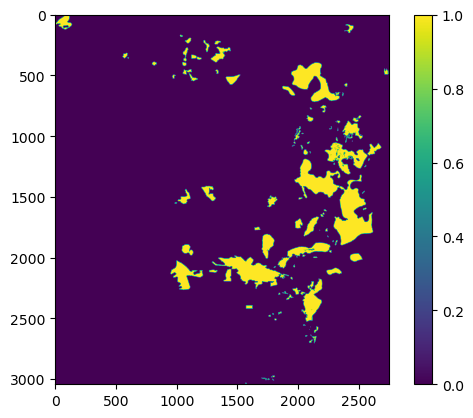

In [10]:
plt.imshow((aoh != 0).astype(int).squeeze(), vmin = 0, vmax = 1)
plt.colorbar();

In [11]:
# Clipping the predictor rasters to the bounds of the AOH
predictor_stack_clipped = predictor_stack.rio.clip_box(*aoh.rio.bounds())

#  making sure the predictor stack is perfectly aligned w/AOH
predictor_stack_clipped = predictor_stack_clipped.rio.reproject_match(aoh)

In [12]:
# Masking predictions outside of the AOH & tropical forest zone (the intersection of the two)
aoh_in_forest_zone = aoh.rio.clip(tropical_zone).fillna(0) # making sure to set NAs back to 0

initial_num_pixels = int(aoh.where(aoh != 0).count())
new_num_pixels = int(aoh_in_forest_zone.where(aoh_in_forest_zone != 0).count())
print(f'{initial_num_pixels - new_num_pixels} pixels dropped (in AOH, but outside of tropical forest zone)')

#  applying to the predictor stack
predictor_stack_clipped = predictor_stack_clipped.where(aoh_in_forest_zone != 0)

277604 pixels dropped (in AOH, but outside of tropical forest zone)


In [13]:
# Extracting the data to numpy + reshaping to get it in a "tabular" format
predictor_stack_np = predictor_stack_clipped.to_array().variable.values.squeeze(axis = 3)
num_y, num_x = predictor_stack_np[0].shape
predictors_tabular = predictor_stack_np.reshape(predictor_stack_np.shape[0], num_y * num_x).transpose()
print(f'Originally {predictors_tabular.shape[0]} pixels to predict on (w/NAs)')

#  tossing nan rows, but keeping track of where they are for reshaping back to raster later
nan_mask = np.any(np.isnan(predictors_tabular), axis = 1)
predictors_tabular_no_nan = predictors_tabular[~nan_mask, : ]

pixels_left = predictors_tabular_no_nan.shape[0]
print(f'Now only {pixels_left} pixels to predict on (removing all NAs)')

#  checking if we drop any pixels within the AOH
if pixels_left < new_num_pixels:
    print()
    print(f'DROPPED {int(new_num_pixels - pixels_left)} PIXELS!')

Originally 7826832 pixels to predict on (w/NAs)
Now only 239132 pixels to predict on (removing all NAs)

DROPPED 36 PIXELS!


In [14]:
# Putting data in a Pandas DataFrame so the predict function of the hurdle model can grab the right vars
predictors_tabular_no_nan = pd.DataFrame(predictors_tabular_no_nan, columns = list(predictor_stack_clipped.keys()))

#  adding the same body mass value to each row - African forest elephant
#   - EltonTraits only has the combined "African elephant", before species were split
body_masses = {'african forest' : 3940.03 * 1000,
               'african savannah' : 3940.03 * 1000,
               'asian' : 2915.04 * 1000}

if model_to_use == 'pymer':
    bm = np.log10(mammals_data['Body_Mass'])
    bm_mean, bm_std = bm.mean(), bm.std()
    
    elephant_body_mass = (np.log10(body_masses[species]) - bm_mean) / bm_std
else:
    bm = mammals_data['Body_Mass']
    bm_mean, bm_std = bm.mean(), bm.std()
    
    elephant_body_mass = (body_masses[species] - bm_mean) / bm_std

predictors_tabular_no_nan['Body_Mass'] = elephant_body_mass

#  apply the trained hurdle model to each pixel iteratively
pred = model.predict(predictors_tabular_no_nan)
pred[pred != 0] = np.exp(pred[pred != 0]) # back-transforming log RRs

In [15]:
# Putting the dataset all back together in a predicted raster
pred_tabular = np.empty(shape = predictors_tabular.shape[0])
pred_tabular.fill(np.nan)
pred_tabular[~nan_mask] = pred # one prediction for each pixel, w/nans put back in the right place

#  reshaping back to raster format + converting back to xarray
pred_raster = pred_tabular.transpose().reshape(num_y, num_x)
pred_raster_xr = xr.zeros_like(aoh_in_forest_zone)
pred_raster_xr.values = np.expand_dims(pred_raster, axis = 0)

pred_raster_xr

<xarray.DataArray (band: 1, y: 2886, x: 2712)> Size: 63MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 22kB -3.125 -3.108 -3.092 ... 42.03 42.04 42.06
  * y            (y) float64 23kB 14.0 13.98 13.96 ... -34.05 -34.07 -34.09
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

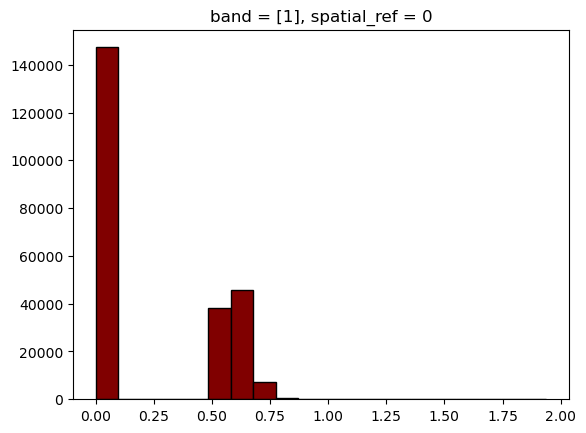

In [16]:
# Quick look at the distribution of predicted RR values
pred_raster_xr.plot.hist(bins = 20, color = 'maroon', edgecolor = 'black')
plt.show()

In [17]:
# Saving back to TIF using rasterio
if save_raster:
    species_name = species.replace(' ', '_')
    pred_raster_xr.rio.to_raster(f'/Users/emiliolr/Desktop/phd-exploratory-work/results/elephants/predicted_raster_{species_name}_{model_to_use}.tif', dtype = 'float32')

# Proof of concept of applying pressure map to AOH

In [18]:
# What portion of the AOH's pixels has predictions?
aoh_num_pixels = float((aoh != 0).sum())
pixels_w_preds = float(((aoh != 0) & (~xr.ufuncs.isnan(pred_raster_xr))).sum())

print(f'{round(pixels_w_preds / aoh_num_pixels * 100, 2)}% of pixels in the AOH have hunting predictions')

46.27% of pixels in the AOH have hunting predictions


In [20]:
# Putting ones (no hunting effect) in locations with no predictions
pred_raster_xr = pred_raster_xr.rio.reproject_match(aoh)

no_pred_mask = ((aoh != 0) & (xr.ufuncs.isnan(pred_raster_xr)))
test = pred_raster_xr.where(~no_pred_mask, other = 1)

In [52]:
# Elementwise multiplication with AOH raster, now not binarizing
cur_aoh = float(aoh.sum()) / (1000 * 1000) # convert to KM^2
aoh_w_hunting_raster = aoh * test
aoh_w_hunting = float((aoh_w_hunting_raster).sum()) / (1000 * 1000)

pct_change = (aoh_w_hunting - cur_aoh) / cur_aoh
print(f'{round(pct_change * 100, 2)}% change in AOH due to hunting')

-92.64% change in AOH due to hunting


In [ ]:
# Saving the result for sanity-checking in QGIS
species_name = species.replace(' ', '_')
aoh_w_hunting_raster.rio.to_raster(f'/Users/emiliolr/Desktop/phd-exploratory-work/results/elephants/aoh_w_hunting_{species_name}_{model_to_use}.tif', dtype = 'float32')

# Testing parallelism with `joblib`

In [35]:
def test_func(inp, fixed_param, fp = '/Users/emiliolr/Desktop/testing'):
    output = (inp + 100) / fixed_param
    with open(os.path.join(fp, f'{inp}.txt'), 'w') as f:
        f.write(str(output))
    
    return output

inputs = [i for i in range(20)]
inputs = inputs
fixed_param = 100

# test_func(10, fixed_param)

# num_cores = multiprocessing.cpu_count()
num_cores = 4

processed_list = Parallel(n_jobs = num_cores)(delayed(test_func)(i, fixed_param) for i in inputs)
print(processed_list)

[1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19]


# Initial testing (toy example)

In [ ]:
# Reading arbitrary raster data to fit the model to, just as an example
forest_cover_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/environmental_predictors/forest_cover/hansen2013/hansen_forest_cover_2000.tif'
pop_dens_fp = '/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/socioeconomic_predictors/human_population_density/gpw-v4/gpw-v4-population-density-rev11_2000_30_sec_tif/gpw_v4_population_density_rev11_2000_30_sec.tif'

forest_cover = rxr.open_rasterio(forest_cover_fp)
pop_dens = rxr.open_rasterio(pop_dens_fp)

#  resampling population density to match forest cover
pop_dens_resampled = pop_dens.rio.reproject_match(forest_cover)
pop_dens_resampled = pop_dens_resampled.where(pop_dens_resampled > 0) # replacing fill values w/nan

In [ ]:
# Stacking the two datasets, making sure they align
predictor_stack = forest_cover.to_dataset(name = 'forest_cover')
predictor_stack['pop_dens'] = pop_dens_resampled

predictor_stack

In [ ]:
# Define linear regression model, just to test applying an sklearn model
lr = LinearRegression()

#  setting coefficients, not fitting them... imagining we have a pre-trained model
lr.coef_ = np.array([3, 5])
lr.intercept_ = np.array([10])
lr.n_features_in_ = 2

#  checking that prediction works as expected on an arbitrary array
a = np.array([[1, 2], [1, 2], [5, 6]])
lr.predict(a)

In [ ]:
# Read in an example AOH over which to apply the model
ex_aoh_fp = '/Users/emiliolr/Desktop/phd-exploratory-work/data/62774969_NONBREEDING.tif'
ex_aoh = rxr.open_rasterio(ex_aoh_fp)

ex_aoh

In [ ]:
# Clipping the predictor rasters to the bounds of the AOH + reprojecting to be sure they align
predictor_stack_clipped = predictor_stack.rio.clip_box(*ex_aoh.rio.bounds())
predictor_stack_clipped = predictor_stack_clipped.rio.reproject_match(ex_aoh)
predictor_stack_clipped

In [ ]:
# Zeroing out the bits of the area which AREN'T in the species' AOH
predictor_stack_clipped = predictor_stack_clipped.where(ex_aoh != 0)

In [ ]:
# Extracting the data to numpy + reshaping to get it in a "tabular" format
predictor_stack_np = predictor_stack_clipped.to_array().variable.values.squeeze()
num_y, num_x = predictor_stack_np[0].shape
predictors_tabular = predictor_stack_np.reshape(predictor_stack_np.shape[0], num_y * num_x).transpose()
print(f'Originally {predictors_tabular.shape[0]} pixels to predict on')

#  tossing nan rows, but keeping track of where they are for reshaping back to raster later
nan_mask = np.any(np.isnan(predictors_tabular), axis = 1)
predictors_tabular_no_nan = predictors_tabular[~nan_mask, : ]
print(f'Now only {predictors_tabular_no_nan.shape[0]} pixels to predict on')

In [ ]:
# Apply the "trained" regression model to each pixel iteratively
#  - see this tutorial: https://rse.shef.ac.uk/blog/xarray-for-earth/
#  - for parallelizing predictions: batch data (into many chunks) + use parallel functionality from Joblib?
pred = lr.predict(predictors_tabular_no_nan)

In [ ]:
# Putting the dataset all back together in a predicted raster
pred_tabular = np.empty(shape = predictors_tabular.shape[0])
pred_tabular.fill(np.nan)
pred_tabular[~nan_mask] = pred # one prediction for each pixel, w/nans put back in the right place

#  reshaping back to raster format + converting back to xarray
pred_raster = pred_tabular.transpose().reshape(num_y, num_x)
pred_raster_xr = xr.zeros_like(ex_aoh)
pred_raster_xr.values = np.expand_dims(pred_raster, axis = 0)

pred_raster_xr

In [ ]:
# Saving back to TIF using rasterio
pred_raster_xr.rio.to_raster('../results/testing/predicted_raster.tif', dtype = 'float32')

# Proof of concept-ing

In [ ]:
# Define linear regression model, just to test applying an sklearn model
lr = LinearRegression()

#  setting coefficients, not fitting them... imagining we have a pre-trained model
lr.coef_ = np.array([3, 5])
lr.intercept_ = np.array([10])
lr.n_features_in_ = 2

#  checking that prediction works as expected on an arbitrary array
a = np.array([[1, 2], [1, 2], [5, 6]])
lr.predict(a)

In [ ]:
# Proof of concept of how to deal w/nans in prediction, which arise naturally b/c of, e.g., 
#  oceans or area outside of AOH w/in raster bbox but are needed to recover shape of final raster
b = np.array([[1, 2], [np.nan, 3], [5, 6]]) # here, rows are each a pixel

#  remove nans, for prediction
nan_mask = np.any(np.isnan(b), axis = 1)
b_wo_nan = b[~nan_mask, : ]

#  predict on this data subset
b_preds = lr.predict(b_wo_nan)
print(b_preds)

#  after prediction, put nan rows back
b_post_pred = np.empty(shape = b.shape[0])
b_post_pred.fill(np.nan)

b_post_pred[~nan_mask] = b_preds # one prediction for each pixel, w/nans put back in the right place
print(b_post_pred)

In [ ]:
# Sanity check: does the reshaping to "tabular" from stacked rasters work as expected?
#  - dummy example w/two 3x3 "rasters"
a = np.array([[[1, 2, 3], [4, 5, 6], [7, 8, 9]], [[9, 8, 7], [6, 5, 4], [3, 2, 1]]])
a_tab = a.reshape(a.shape[0], a.shape[1] * a.shape[2]).transpose()

print(a)
print()
print(a_tab)

In [ ]:
# Sanity check: does reversing the reshaping work as intended?
a_pred = (1 * a_tab[ : , 0]) + (2 * a_tab[ : , 1])
a_pred_raster = a_pred.transpose().reshape(a.shape[1], a.shape[2])

print(a_pred)
print()
print(a_pred_raster)